loading data...

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 33444.20it/s]

completed 0.03886818885803223 sec


0.8504385948181152 [0.73065764]
0.681541919708252 [0.7370792]
0.8462939858436584 [0.7220391]
0.6884305477142334 [0.71722186]
0.7045056819915771 [0.73437524]
0.795072078704834 [0.7218985]
0.8253466486930847 [0.73237514]
0.850493848323822 [0.74109405]
0.8776981234550476 [0.72650152]
0.6002784967422485 [0.73664033]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


N#Cc1ccc(OCC(=O)NCc2cccc(CO)c2)cc1 
 N#Cc1ccc(OCC(=O)NCc2cccc(CO)c2)cc1 

CC1(C)OC[C@H]([C@H]2O[C@@H]3OC(C)(C)O[C@@H]3[C@H]2OS(C)(=O)=O)O1 
 CC1(C)OC[C@H]([C@H]2O[C@@H]3OC(C))(OO[C@@H]3[C@H]2OS(C)(=O)=OO)1 

C[C@H](OC(=O)c1ccc2ccccc2n1)C(=O)NCC1CCCCC1 
 C[C@H](OC(=O)c1ccc2ccccc2n1)C(=O)NCCCCCCCC1 

Fc1ccccc1[C@@H](c1nnnn1C1CCCCC1)[NH+]1CCN(c2ccccc2)CC1 
 Fc1ccccc1[C@@H](c1nnnn1C1CCCCC1)[NH+]1CNN(c2ccccc2)CC1 

CC1(C)[C@@H]2CC[C@@]1(CS(=O)(=O)NCCCO)C(=O)C2 
 CC1(C)[C@@H]2CC[C@@]1(CS(=O)(=O)NCCCO)C(=O)C2 

CC(=O)N[C@@H]1C(=O)C[C@@H]2[C@H]3CCC4=CC(=O)CC[C@@]4(C)[C@@H]3CC[C@]12C 
 CC(=O)N[C@@H]1C(=O)C[C@@H]2[C@H]3CCC=4CC(=O)CC[C@@]4(C)[C@@H]3CCCC@]12 

CC[C@](C)(C[NH3+])[C@H](O)c1ccc2c(c1)OCO2 
 CC[C@](C)(C[NH3+])[C@H](O)c1ccc2c(c1)OCO2 

Cc1nc(Br)ccc1NC(=O)NCc1cnn(C)c1 
 Cc1nc(Br)ccc1NC(=O)NCc1cnn(C)c1 

CC[C@@H](C)C(=O)NCC(=O)N(C)[C@@H](C)c1cc(F)ccc1F 
 CC[C@@H](C)C(=O)NCC(=O)N(C)[C@@H](C)c1cc(F)ccc1F 

Cc1ccccc1-c1nn(CN2CCCc3ccc(S(C)(=O)=O)cc32)c(=S)o1 
 Cc1ccccc1-c1nn(CN2CCCc3ccc(S(C)(

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


['CCc1cc(N)c((CC((=O)CCCH]122cccc(C))c2))cc1']

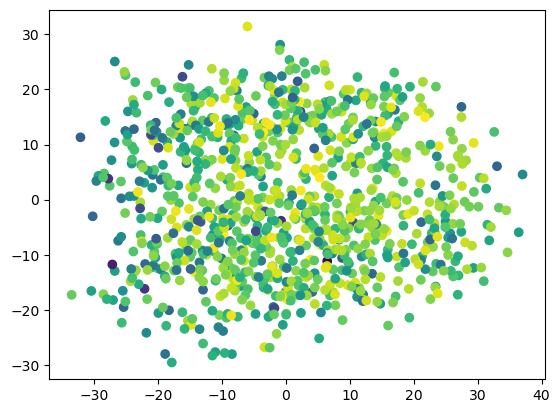

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv_Encoder(nn.Module):
  def __init__(self, vocab_len):
    super(Conv_Encoder,self).__init__()

    self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
    self.bn_1 = nn.BatchNorm1d(9)
    self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
    self.bn_2 = nn.BatchNorm1d(9)
    self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
    self.bn_3 = nn.BatchNorm1d(10)
    self.fc_1 = nn.Linear(10*(vocab_len-26),435)
    self.relu = nn.ReLU()
    self.bn_4 = nn.BatchNorm1d(435)
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.swapaxes(1,2)
    x = self.relu(self.conv_1(x))
    x = self.bn_1(x)
    x = self.relu(self.conv_2(x))
    x = self.bn_2(x)
    x = self.relu(self.conv_3(x))
    x = self.bn_3(x)
    x = x.reshape(batch_size, -1)
    x = self.relu(self.fc_1(x))
    x = self.bn_4(x)
    return x
  
class GRU_Decoder(nn.Module):
  def __init__(self, vocab_size):
    super(GRU_Decoder,self).__init__()
    self.fc_1 = nn.Linear(292, 292)
    self.bn_1 = nn.BatchNorm1d(292)
    self.gru = nn.GRU(292, 501, 3, batch_first=True)
    self.bn_2 = nn.BatchNorm1d(501)
    self.fc_2 = nn.Linear(501, vocab_size)
    self.relu = nn.ReLU()
  def forward(self, z):
    batch_size = z.shape[0]
    z = self.relu(self.fc_1(z))
    z = self.bn_1(z)
    z = z.unsqueeze(1).repeat(1, 120, 1)
    z_out, hidden = self.gru(z)
    z_out = self.bn_2(z_out.swapaxes(1,2)).swapaxes(1,2)
    z_logit = self.fc_2(z_out)
    return z_logit

class Predictor(nn.Module):
  def __init__(self, latent_dim):
    super(Predictor, self).__init__()
    self.pred_fc1 = nn.Linear(292, 100)
    self.pred_fc2 = nn.Linear(100, 1)
  def forward(self, mu):
    z = F.selu(self.pred_fc1(mu))
    z = self.pred_fc2(z)
    return F.sigmoid(z)


class Molecule_VAE(nn.Module):
  def __init__(self, vocab_size = 35, latent_dim=292):
    super(Molecule_VAE, self).__init__()
    self.encoder = Conv_Encoder(vocab_size)
    self.decoder = GRU_Decoder(vocab_size)
    self.predictor = Predictor(latent_dim)
    self.enc_mu = nn.Linear(435,292)
    self.enc_log_var = nn.Linear(435,292)
  def _sample_latent(self, h_enc):
    """
    Return the latent normal sample z ~ N(mu, sigma^2)
    """
    mu = self.enc_mu(h_enc)
    log_var = self.enc_log_var(h_enc)
    sig = torch.exp(0.5*log_var)
    # Reparameterization trick
    std_z = torch.randn(sig.size()).float().to(mu.device) 
    z = mu + sig * std_z
    var = torch.exp(log_var)
    return z, mu, var

  def forward(self, x):
    """Forward Function which passes the data through entire model"""
    self.h_enc = self.encoder(x.swapaxes(1,2))
    z, mu, var = self._sample_latent(self.h_enc)
    y = self.predictor(mu)
    recon_x = self.decoder(z)
    return recon_x, mu, var, y

from time import time
import random
import numpy as np
import torch.optim as optim

def use_model(data_loader, model, criterion, optimizer, i_iter, mode, name = None):
  assert mode in ['train','predict']
  #switch to model mode
  if mode == 'train':
    model.train()
  elif mode == 'predict':
    model.eval()

  X_true = []
  X_pred = [] 
  Y_true = []
  Y_pred = []
  mus = []
  idxss=[]
  losses = []

  for idxs, ys,xs in data_loader: # loop for each batch
    # move input to cuda
    if next(model.parameters()).is_cuda:
      xs = xs.to(device='cuda')
      ys = ys.to(device='cuda')
        
    #compute output
    if mode == 'train':
      recon_batch, mu, var, y_p = model(xs)
    elif mode == 'predict':
      with torch.no_grad(): # it does not compute the gradient. so it's faster
        recon_batch, mu, var, y_p = model(xs)
    # loss
      
    loss = criterion(recon_batch, xs, mu, var,ys,y_p)
    
    # Backward propagation
    if mode == 'train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    losses.append(float(loss))
    X_pred += recon_batch.cpu().tolist()
    Y_pred += y_p.cpu().tolist()
    X_true += xs.cpu().tolist()
    Y_true += ys.cpu().tolist() # list concatenation
    mus += mu.cpu().tolist()
    idxss += idxs.tolist()
  return X_pred,X_true,Y_pred,Y_true,np.mean(losses),mus,idxss

from torch.utils.data import DataLoader, random_split
def loss_function(recon_x, x, mu, var,y_true,y_pred):
    BCE = F.cross_entropy(recon_x.swapaxes(1,2), x.swapaxes(1,2), reduction='mean')
    KLD = 0.5 * torch.mean(-torch.log(var) - 1 + mu.pow(2) + var)
    MSE = torch.mean((y_true-y_pred)**2)
    return BCE - 1e-6*KLD + 1e-6*0.5*MSE

################################ Input ####################################
# data
data_path='250k_zinc_w_qed.csv'

# Training
batch_size = 64
lr = 0.0003
nepochs = 1000
cuda = True
seed = 1234
###########################################################################

# Loading data
print('loading data...',end=''); t = time()
data = Data(data_path,ndata=1000)
print('completed', time()-t,'sec')

data_train, data_test = random_split(data,[0.90,0.1]) 
dataloader_train = DataLoader(data_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=64, shuffle=True)

#build model
model = Molecule_VAE()
if cuda:
  if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model,device_ids=[0])
  model.cuda()

## Training
criterion = loss_function # 
optimizer = optim.Adam(model.parameters(),lr,weight_decay= 0) # 0 means no penalty
model.load_state_dict(torch.load('Weights.pth.tar'))
X_pred,X_true,Y_pred,Y_true,losses,mus,idxss = use_model(train_loader,model,criterion,optimizer,0,'predict') # training model
X_true = np.array(X_true)
X_pred = F.softmax(torch.Tensor(X_pred),dim=2).numpy()
Y_true = np.array(Y_true)
Y_pred = np.array(Y_pred)

for t,p in zip(Y_true[:10],Y_pred[:10]):
  print(t,p)
  
for s_pred,s_true in zip(data.one_hot_to_smiles(X_pred[:10,:,:]),data.one_hot_to_smiles(X_true[:10,:,:])):
  print(s_true,'\n',s_pred,'\n')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
mus = np.array(mus)
pca = PCA(2)
zs = pca.fit_transform(mus)
plt.scatter(zs[:,0],zs[:,1],c=Y_true)
# sample
z = torch.Tensor(pca.inverse_transform([[0,10]])).cuda()
data.one_hot_to_smiles(model.decoder(z).cpu().detach())
